<a href="https://colab.research.google.com/github/josephassiga/tensorflow-and-keras-tutorial/blob/main/W4/Lab5/W4_Lab_4_timeseries_RNN_Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using recurrent dropout to fight overfitting





There’s a family of neural network architectures designed specifically for this use
case: recurrent neural networks. Among them, the Long Short Term Memory (LSTM)
layer has long been very popular. We’ll see in a minute how these models work, but
let’s start by giving the LSTM layer a try

In [16]:
from tensorflow import keras
from tensorflow.keras import layers

In [17]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-01 08:54:13--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.193.224, 52.217.41.30, 16.182.36.160, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.193.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.2’

jena_climate_2009_2 100%[===================>]  12.94M  13.7MB/s    in 0.9s    

2024-04-01 08:54:15 (13.7 MB/s) - ‘jena_climate_2009_2016.csv.zip.2’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Now inspecting the data of the Jena weather dataset

In [18]:
import os

filename = os.path.join("jena_climate_2009_2016.csv")

with open(filename) as f:
  data = f.read()

# Retrieve all the content of the file.
lines = data.split("\n")
# Get the header of the file.
header = lines[0].split(",")
# Get other line execpt the header line.
lines = lines[1:]
print(f"Header : {header}")
print(f"Size of the file : {len(lines)}")
print(lines[0].split(",")[:])

Header : ['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
Size of the file : 420451
['01.01.2009 00:10:00', '996.52', '-8.02', '265.40', '-8.90', '93.30', '3.33', '3.11', '0.22', '1.94', '3.12', '1307.75', '1.03', '1.75', '152.30']


# Parsing the data

(420451, 14)


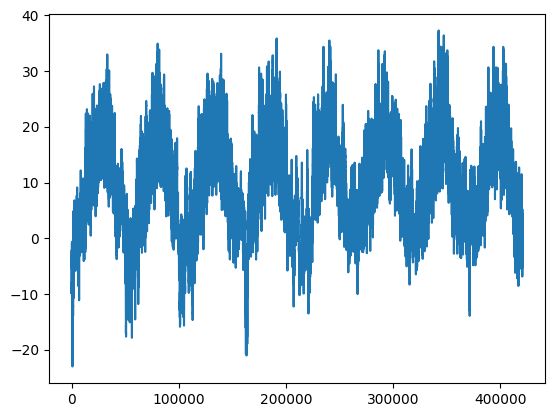

In [21]:
import numpy as np
from matplotlib import pyplot as plt

temperature = np.zeros(len(lines))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  # For each line, i will only take data exacpt the Date Time
  values = [float(x) for x in line.split(",")[1:]]
  # We store column 1 in the temperature array
  temperature[i] = values[1]
  # We store all columns(including the temperature) in the raw_data
  raw_data[i,:] = values[:]

print(raw_data.shape)
plt.plot(range(len(temperature)), temperature)

Computing the number of samples we’ll use for each data split

In [24]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


# Preparing the data
The exact formulation of the problem will be as follows: given data covering the previous five days and sampled once per hour, can we predict the temperature in 24 hours?

 First, let’s preprocess the data to a format a neural network can ingest. This is
easy: the data is already numerical, so you don’t need to do any vectorization. But
each timeseries in the data is on a different scale (for example, atmospheric pressure, measured in mbar, is around 1,000, while H2OC, measured in millimoles per
mole, is around 3). We’ll normalize each timeseries independently so that they all
take small values on a similar scale. We’re going to use the first 210,225 timesteps as
training data, so we’ll compute the mean and standard deviation only on this fraction of the data


In [25]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

Instantiating datasets for training, validation and testing

In [23]:
from tensorflow import keras

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
 raw_data[:-delay],
 targets=temperature[delay:],
 sampling_rate=sampling_rate,
 sequence_length=sequence_length,
 shuffle=True,
 batch_size=batch_size,
 start_index=0,
 end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
 raw_data[:-delay],
 targets=temperature[delay:],
 sampling_rate=sampling_rate,
 sequence_length=sequence_length,
 shuffle=True,
 batch_size=batch_size,
 start_index=num_train_samples,
 end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
 raw_data[:-delay],
 targets=temperature[delay:],
 sampling_rate=sampling_rate,
 sequence_length=sequence_length,
 shuffle=True,
 batch_size=batch_size,
 start_index=num_train_samples + num_val_samples)

for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


Create a model with Sequencial API

In [ ]:
model = keras.Sequential([
    #RNN
    keras.layers.LSTM(32, recurrent_dropout=0.25, input_shape=(sequence_length, raw_data.shape[-1])),
    keras.layers.Dropout(0.5),

    #DNN
    keras.layers.Dense(1)
])


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                6016      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6049 (23.63 KB)
Trainable params: 6049 (23.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Create Model with Funcctional API

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                6016      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6049 (23.63 KB)
Trainable params: 6049 (23.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Training and evaluating a densely connected model

In [ ]:
callbacks = [
 keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
 save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
 epochs=10,
 validation_data=val_dataset,
 callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 205s 247ms/step - loss: 27.2737 - mae: 3.8530 - val_loss: 9.6417 - val_mae: 2.4113
Epoch 2/10
819/819 [==============================] - 218s 266ms/step - loss: 14.7631 - mae: 2.9840 - val_loss: 9.3473 - val_mae: 2.3759
Epoch 3/10
819/819 [==============================] - 204s 249ms/step - loss: 13.9028 - mae: 2.8933 - val_loss: 9.5465 - val_mae: 2.4106
Epoch 4/10
819/819 [==============================] - 203s 248ms/step - loss: 13.3499 - mae: 2.8334 - val_loss: 9.2814 - val_mae: 2.3656
Epoch 5/10
819/819 [==============================] - 218s 266ms/step - loss: 12.8256 - mae: 2.7766 - val_loss: 9.3731 - val_mae: 2.3754
Epoch 6/10
819/819 [==============================] - 205s 250ms/step - loss: 12.4417 - mae: 2.7337 - val_loss: 9.2956 - val_mae: 2.3627
Epoch 7/10
819/819 [==============================] - 218s 265ms/step - loss: 12.1272 - mae: 2.7014 - val_loss: 9.3668 - val_mae: 2.3737
Epoch 8/10
819/819 [=====================

Plotting results

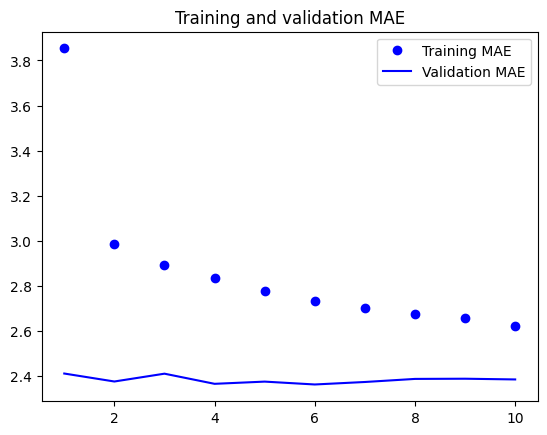

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

A major characteristic of all neural networks you’ve seen so far, such as densely connected networks and convnets, is that they have no memory. Each input shown to
them is processed independently, with no state kept between inputs

# Stacking recurrent layers

In [27]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
 save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
 epochs=10,
 validation_data=val_dataset,
 callbacks=callbacks)

model = keras.models.load_model("jena_stacked_gru_dropout.keras")

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 396s 476ms/step - loss: 38.3035 - mae: 4.7584 - val_loss: 22.6443 - val_mae: 3.7295
Epoch 2/10
819/819 [==============================] - 352s 429ms/step - loss: 22.5545 - mae: 3.7349 - val_loss: 21.6197 - val_mae: 3.7076
Epoch 3/10
819/819 [==============================] - 343s 418ms/step - loss: 20.9948 - mae: 3.6092 - val_loss: 21.9237 - val_mae: 3.7530
Epoch 4/10
819/819 [==============================] - 352s 429ms/step - loss: 20.5534 - mae: 3.5620 - val_loss: 15.3580 - val_mae: 3.0784
Epoch 5/10
819/819 [==============================] - 341s 416ms/step - loss: 20.1427 - mae: 3.5299 - val_loss: 16.3309 - val_mae: 3.1802
Epoch 6/10
819/819 [==============================] - 384s 468ms/step - loss: 19.8498 - mae: 3.5036 - val_loss: 17.8409 - val_mae: 3.3587
Epoch 7/10
819/819 [==============================] - 344s 420ms/step - loss: 19.6030 - mae: 3.4805 - val_loss: 18.4547 - val_mae: 3.4132
Epoch 8/10
819/819 [==============

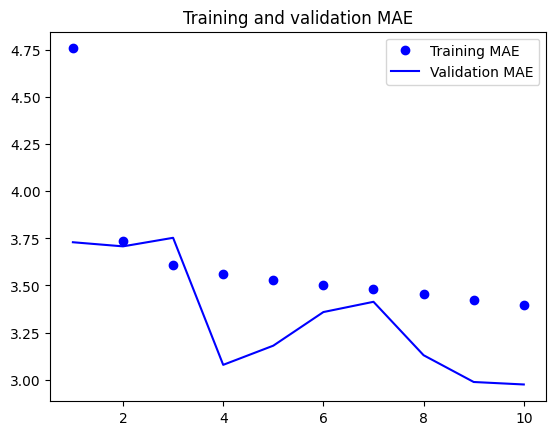

In [28]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# Using bidirentional RNNs

A bidirectional
RNN is a common RNN variant that can offer greater performance than a regular
RNN on certain tasks. It’s frequently used in natural language processing—you could
call it the Swiss Army knife of deep learning for natural language processing

A bidirectional RNN exploits the order sensitivity of RNNs: it uses two regular RNNs, such as the GRU and LSTM layers you’re already familiar with,
each of which processes the input sequence in one direction (chronologically and
antichronologically), and then merges their representations. By processing a sequence
both ways, a bidirectional RNN can catch patterns that may be overlooked by a unidirectional RNN.

In [29]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
 keras.callbacks.ModelCheckpoint("jena_bidirectional.keras",
 save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
 epochs=10,
 validation_data=val_dataset,
 callbacks=callbacks)


model = keras.models.load_model("jena_bidirectional.keras")

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 168s 199ms/step - loss: 94.7703 - mae: 7.7977 - val_loss: 53.6318 - val_mae: 5.9145
Epoch 2/10
819/819 [==============================] - 158s 193ms/step - loss: 58.6067 - mae: 6.0396 - val_loss: 45.2975 - val_mae: 5.3606
Epoch 3/10
819/819 [==============================] - 148s 181ms/step - loss: 49.8596 - mae: 5.4607 - val_loss: 38.5642 - val_mae: 4.8976
Epoch 4/10
819/819 [==============================] - 152s 185ms/step - loss: 42.5067 - mae: 4.9616 - val_loss: 33.2825 - val_mae: 4.4974
Epoch 5/10
819/819 [==============================] - 159s 194ms/step - loss: 36.7459 - mae: 4.5808 - val_loss: 27.5863 - val_mae: 4.0397
Epoch 6/10
819/819 [==============================] - 160s 195ms/step - loss: 32.1993 - mae: 4.2870 - val_loss: 24.8954 - val_mae: 3.8540
Epoch 7/10
819/819 [==============================] - 160s 195ms/step - loss: 28.8241 - mae: 4.0725 - val_loss: 22.4399 - val_mae: 3.6589
Epoch 8/10
819/819 [==============

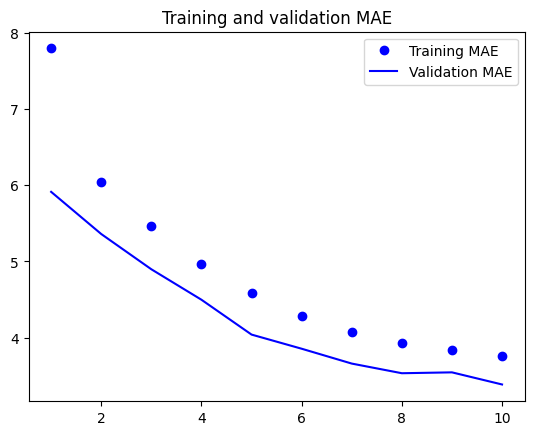

In [30]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()